In [1]:
# =======================
# 0. Install Dependensi 
# =======================

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm

In [3]:
# =======================
# 1. Load Dataset
# =======================

In [4]:
dataset_folder = r'D:\03. PPDM\Audio-D1-SVM'

paths, labels = [], []
for dirname, _, filenames in os.walk(dataset_folder):
    for filename in filenames:
        if filename.endswith('.wav'):
            paths.append(os.path.join(dirname, filename))
            label = filename.split('_')[-1].split('.')[0].lower()
            labels.append(label)

data = pd.DataFrame({'path': paths, 'emotion': labels})
data['actor'] = data['path'].apply(lambda x: os.path.basename(x).split('_')[0])
data = data.groupby('emotion').filter(lambda x: len(x) >= 2)

print(f"Total Audio Files: {len(data)}")
print(data['emotion'].value_counts())

Total Audio Files: 2800
emotion
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64


In [5]:
# =======================
# 2. Visualisasi Dataset
# =======================

C:\Users\sucit\AppData\Local\Temp\ipykernel_9272\1166499303.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='emotion', order=data['emotion'].value_counts().index, palette="viridis")


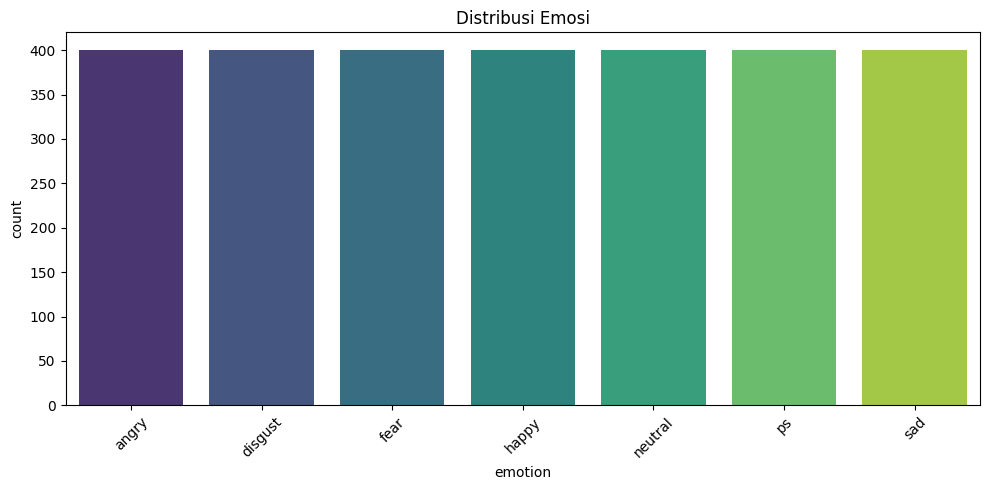

C:\Users\sucit\AppData\Local\Temp\ipykernel_9272\1166499303.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='actor', palette="pastel")


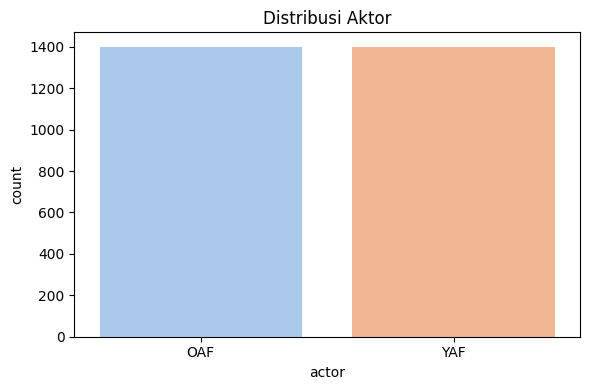

In [6]:
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='emotion', order=data['emotion'].value_counts().index, palette="viridis")
plt.title("Distribusi Emosi")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='actor', palette="pastel")
plt.title("Distribusi Aktor")
plt.tight_layout()
plt.show()

In [7]:
# =======================
# 3. Visualisasi Sinyal
# =======================

In [8]:
sampled = data.groupby('emotion').first().reset_index()
for i, row in sampled.iterrows():
    y, sr = librosa.load(row['path'], sr=22050)
    y = librosa.util.normalize(y)
    y_trimmed, _ = librosa.effects.trim(y)

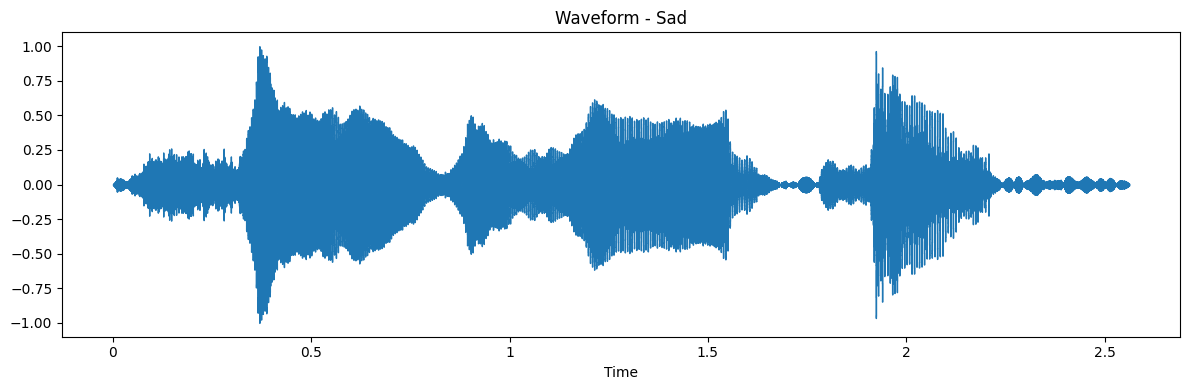

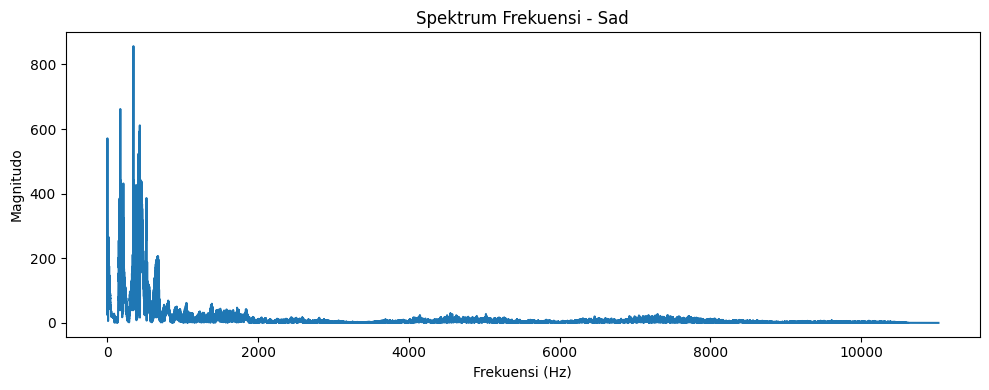

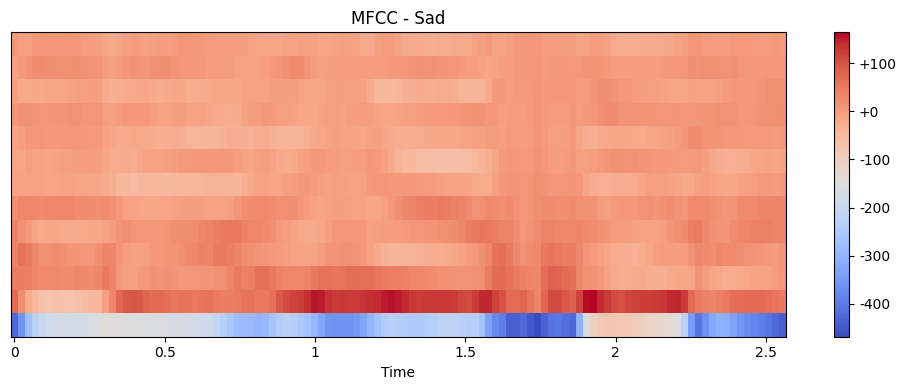

In [9]:
    # Waveform (Domain Waktu)
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y_trimmed, sr=sr)
    plt.title(f"Waveform - {row['emotion'].capitalize()}")
    plt.tight_layout()
    plt.show()

    # FFT (Domain Frekuensi)
    fft = np.fft.fft(y_trimmed)
    magnitude = np.abs(fft)
    frequency = np.linspace(0, sr, len(magnitude))
    half_range = len(magnitude) // 2

    plt.figure(figsize=(10, 4))
    plt.plot(frequency[:half_range], magnitude[:half_range])
    plt.title(f"Spektrum Frekuensi - {row['emotion'].capitalize()}")
    plt.xlabel("Frekuensi (Hz)")
    plt.ylabel("Magnitudo")
    plt.tight_layout()
    plt.show()

    # MFCC (Domain Waktu-Frekuensi)
    mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
    plt.colorbar(format="%+2.f")
    plt.title(f"MFCC - {row['emotion'].capitalize()}")
    plt.tight_layout()
    plt.show()

In [10]:
# =======================
# 4. Preprocessing & Augmentasi
# =======================

In [13]:
def full_preprocessing(file_path, sr=22050, duration=3.0):
    y, _ = librosa.load(file_path, sr=sr)
    y = librosa.util.normalize(y)
    y, _ = librosa.effects.trim(y)
    desired_len = int(sr * duration)
    y = y[:desired_len] if len(y) >= desired_len else np.pad(y, (0, desired_len - len(y)), 'constant')
    augmented = [
        y,
        y + 0.005 * np.random.randn(len(y)),
        librosa.effects.pitch_shift(y, sr=sr, n_steps=4)[:desired_len],
        librosa.util.fix_length(librosa.effects.time_stretch(y, rate=0.8), size=desired_len)
    ]
    return augmented

def extract_features(y, sr=22050):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)
    zcr = librosa.feature.zero_crossing_rate(y).mean()
    rms = librosa.feature.rms(y=y).mean()
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    return np.concatenate([mfcc, [zcr, rms, centroid]])

def extract_dataset_features(data):
    X, y = [], []
    for _, row in tqdm(data.iterrows(), total=len(data)):
        signals = full_preprocessing(row['path'])
        for signal in signals:
            X.append(extract_features(signal))
            y.append(row['emotion'])
    return np.array(X), np.array(y)

In [14]:
# =======================
# 5. Split & Encode (Safe
# =======================

In [15]:
label_counts = data['emotion'].value_counts()
min_label_count = label_counts.min()

if min_label_count >= 2:
    stratify_option = data['emotion']
else:
    stratify_option = None
    print("[WARNING] Stratify dinonaktifkan karena ada label dengan kurang dari 2 data")

train_data, test_data = train_test_split(
    data,
    test_size=0.2,
    stratify=stratify_option,
    random_state=42
)
print(f"Train: {len(train_data)}, Test: {len(test_data)}")

X_train, y_train = extract_dataset_features(train_data)
X_test, y_test = extract_dataset_features(test_data)

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train: 2240, Test: 560


100%|██████████| 560/560 [01:49<00:00,  5.12it/s]


In [16]:
# =======================
# 6. Manual SVM RBF + Hyperparameter Tuning
# =======================

In [17]:
# =======================
# Fungsi Akurasi Manual
# =======================
def manual_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [18]:
# =======================
# RBF Kernel (Vektorisasi)
# =======================
def rbf_kernel(X1, X2, gamma):
    X1_sq = np.sum(X1**2, axis=1).reshape(-1, 1)
    X2_sq = np.sum(X2**2, axis=1).reshape(1, -1)
    dist_sq = X1_sq + X2_sq - 2 * np.dot(X1, X2.T)
    return np.exp(-gamma * dist_sq)

In [19]:
# =======================
# Train SVM (Manual Gradient Ascent)
# =======================
def train_svm_rbf(X, y, C=1.0, gamma=0.01, lr=0.001, epochs=50):
    n = X.shape[0]
    alpha = np.zeros(n)
    Y = np.where(y == 1, 1, -1)
    K = rbf_kernel(X, X, gamma)

    for _ in range(epochs):
        for i in range(n):
            grad = 1 - np.sum(alpha * Y * K[:, i] * Y[i])
            alpha[i] += lr * grad
            alpha[i] = np.clip(alpha[i], 0, C)

    support_idx = alpha > 1e-5
    b = np.mean([
        Y[i] - np.sum(alpha[support_idx] * Y[support_idx] * K[i, support_idx])
        for i in range(n) if support_idx[i]
    ])
    return alpha, support_idx, b, X[support_idx], Y[support_idx], gamma

In [20]:
# =======================
# Predict SVM
# =======================
def predict_svm_rbf(X_train, X_test, alpha, support_idx, b, support_vectors, support_labels, gamma):
    K = rbf_kernel(X_test, support_vectors, gamma)
    return np.sign(np.dot(K, alpha[support_idx] * support_labels) + b)

In [21]:
# =======================
# One-vs-Rest SVM
# =======================
def one_vs_rest_svm(X, y, C=1.0, gamma=0.01, lr=0.001, epochs=50):
    models = []
    classes = np.unique(y)
    for cls in classes:
        y_bin = np.where(y == cls, 1, 0)
        alpha, support_idx, b, sv, sl, gamma_used = train_svm_rbf(X, y_bin, C, gamma, lr, epochs)
        models.append((cls, alpha, support_idx, b, sv, sl, gamma_used))
    return models

def predict_ovr(models, X):
    votes = []
    for cls, alpha, support_idx, b, sv, sl, gamma in models:
        y_pred = predict_svm_rbf(sv, X, alpha, support_idx, b, sv, sl, gamma)
        votes.append(y_pred)
    votes = np.array(votes)
    return np.argmax(votes, axis=0)

In [22]:
# =======================
# Training dan Hyperparameter Tuning
# =======================
best_acc = 0
best_model = None
best_pred = None
best_C = None
best_gamma = None

for C in [0.1, 1, 10]:
    for gamma in [0.001, 0.01, 0.1]:
        print(f"Training model: C={C}, gamma={gamma}")
        models = one_vs_rest_svm(X_train_scaled, y_train_enc, C=C, gamma=gamma, lr=0.001, epochs=50)
        y_val_pred = predict_ovr(models, X_test_scaled)
        acc = manual_accuracy(y_test_enc, y_val_pred)
        print(f"Accuracy: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_model = models
            best_pred = y_val_pred
            best_C = C
            best_gamma = gamma

print("\n=============================")
print("Parameter terbaik:")
print(f"C = {best_C}, gamma = {best_gamma}, Accuracy = {best_acc:.4f}")
print("=============================\n")

Training model: C=0.1, gamma=0.001
Accuracy: 0.2143
Training model: C=0.1, gamma=0.01
Accuracy: 0.5482
Training model: C=0.1, gamma=0.1
Accuracy: 0.8679
Training model: C=1, gamma=0.001
Accuracy: 0.2143
Training model: C=1, gamma=0.01
Accuracy: 0.5482
Training model: C=1, gamma=0.1
Accuracy: 0.8679
Training model: C=10, gamma=0.001
Accuracy: 0.2143
Training model: C=10, gamma=0.01
Accuracy: 0.5482
Training model: C=10, gamma=0.1
Accuracy: 0.8679

Parameter terbaik:
C = 0.1, gamma = 0.1, Accuracy = 0.8679



In [23]:
# ==========================
# 7. Final Evaluation
# ==========================


Final Accuracy: 0.8679

Classification Report:
  Label  Precision  Recall  F1-Score
  angry       0.57    0.99      0.73
disgust       0.99    0.92      0.95
   fear       0.95    0.93      0.94
  happy       0.93    0.72      0.81
neutral       0.96    0.92      0.94
     ps       0.97    0.63      0.77
    sad       0.97    0.97      0.97


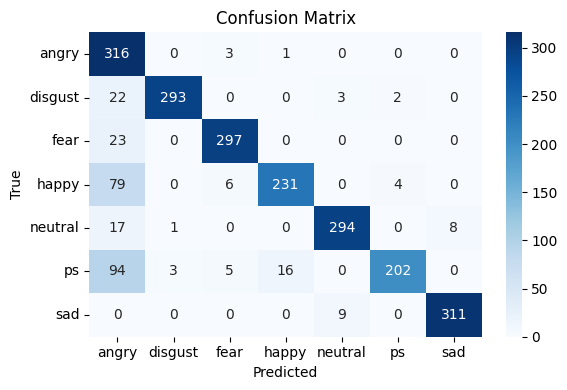

In [26]:
def manual_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def manual_classification_report(y_true, y_pred, label_names):
    num_classes = len(label_names)
    report_data = []

    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))  
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        report_data.append({
            'Label': label_names[i],
            'Precision': round(precision, 2),
            'Recall': round(recall, 2),
            'F1-Score': round(f1, 2)
        })

    report_df = pd.DataFrame(report_data)
    print("\nClassification Report:")
    print(report_df.to_string(index=False))

def manual_confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

def evaluate_model(y_true, y_pred, label_names):
    acc = manual_accuracy(y_true, y_pred)
    print(f"\nFinal Accuracy: {acc:.4f}")
    manual_classification_report(y_true, y_pred, label_names)
    
    cm = manual_confusion_matrix(y_true, y_pred, num_classes=len(label_names))
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
evaluate_model(y_test_enc, best_pred, label_names=label_encoder.classes_)

In [27]:
import joblib

joblib.dump(best_model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']